# Analyzing the encodings produced by a network

Analyses based on distance to the reference object and also the order in which the objects collided.

In [29]:
from collections import defaultdict

import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression

from loader import DSET_SFXES

In [7]:
%matplotlib inline

In [8]:
dset_names = ['test', 'obj3', 'obj9']
num_obj = {'test': 6, 'obj3': 3, 'obj9': 9}
log_base = '/om/user/dzd123/logs/498/'

In [9]:
encs_and_ys = {}
for dset_name in dset_names:
    f = np.load(os.path.join(log_base, 'enc_' + dset_name + '_save.npz'))
    encs_and_ys[dset_name] = {'enc': f['enc'], 'y': f['y']}

In [10]:
def to_log_ratios(y):
    y = np.log(y)
    y -= y[:,0:1]
    return y

In [11]:
num_points = 0
test_points = 5000
data_file = '/om/user/dzd123/physics_b.h5'
f = h5py.File(data_file, 'r')
y_true = {}
col = {}
for dset_name in dset_names:
    y_true[dset_name] = to_log_ratios(f['y'+DSET_SFXES[dset_name]][-test_points:])
    col[dset_name] = f['col'+DSET_SFXES[dset_name]][-test_points:]

In [12]:
for dset in dset_names:
    # Check to make sure we're dealing with correct portion of test set
    assert (y_true[dset] == encs_and_ys[dset]['y']).all()
    # Check to make sure only two objects are marked as colliding per frame
    assert not np.any(np.sum(col[dset][:,:,:], axis=2) > 2)

In [13]:
# Get a list of tuples representing the ordering of collisions for a given sample of col
def get_collisions(col_sample):
    collisions = []
    for row in col_sample:
        c = tuple(np.where(row)[0])
        if len(c) > 0:
            collisions.append(c)
    return collisions
def get_first_ref_col(col_sample):
    collisions = []
    i = 0
    for row in col_sample:
        c = tuple(np.where(row)[0])
        if len(c) > 0:
            if 0 in c:
                return i
            i += 1
    raise RuntimeError('No collisions with reference object found!')
collisions = {}
first_ref_col = {}
for dset in dset_names:
    collisions[dset] = [get_collisions(x) for x in col[dset]]
    first_ref_col[dset] = [get_first_ref_col(x) for x in col[dset]]

## Dependence of R^2 based on when first reference collision occurs

In [14]:
def filter_r2(encs_and_ys, filter_idx):
    for dset in dset_names:
        y_true = encs_and_ys[dset]['y'][filter_idx[dset],:]
        enc = encs_and_ys[dset]['enc'][filter_idx[dset],:,:]
        r2s = []
        for obj_ind in range(y_true.shape[1]):
            X = enc[:,obj_ind,:]
            y = y_true[:,obj_ind]
            model = LinearRegression()
            model.fit(X, y)
            r2s.append( model.score(X, y) )
        print("R^2 {}: {}".format(dset, r2s))

In [15]:
ref_first_idx = {dset: np.array([i for i in range(len(val)) if val[i] == 0]) for dset, val in first_ref_col.items()}
ref_late_idx = {dset: np.array([i for i in range(len(val)) if val[i] >= num_obj[dset] - 2]) for dset, val in first_ref_col.items()}
for dset in dset_names:
    print("Ref first % for {}: {}".format(dset, float(len(ref_first_idx[dset])) / len(col[dset])))
print("")
for dset in dset_names:
    print("Ref late % for {}: {}".format(dset, float(len(ref_late_idx[dset])) / len(col[dset])))

Ref first % for test: 0.3412
Ref first % for obj3: 0.6672
Ref first % for obj9: 0.2602

Ref late % for test: 0.1826
Ref late % for obj3: 0.3328
Ref late % for obj9: 0.1286


In [16]:
print("Overall statistics")
filter_r2(encs_and_ys, {dset: np.array(range(test_points)) for dset in dset_names})
print("\nRef object first")
filter_r2(encs_and_ys, ref_first_idx)
print("\nRef object late")
filter_r2(encs_and_ys, ref_late_idx)

Overall statistics
R^2 test: [1.0, 0.87563419312060575, 0.88034370880656954, 0.87438989153189128, 0.86979767123850638, 0.8735372506228527]
R^2 obj3: [1.0, 0.93974930451070937, 0.9282318014867379]
R^2 obj9: [1.0, 0.75382482774689152, 0.76082118574014601, 0.74972034986846947, 0.75525013640793259, 0.7614015918126078, 0.73727277905768107, 0.7467567071073703, 0.73913437572899543]

Ref object first
R^2 test: [1.0, 0.89303619411481305, 0.88975114067286165, 0.88265207399658774, 0.8830756561047669, 0.89101922321636984]
R^2 obj3: [1.0, 0.94108242859975366, 0.92583913275784646]
R^2 obj9: [1.0, 0.76221985591876074, 0.77348571791959597, 0.76203528997214987, 0.77236405861425539, 0.77848528793688676, 0.78283332897666258, 0.76185737227221761, 0.73363954080859073]

Ref object late
R^2 test: [1.0, 0.84598088195049037, 0.87082077979165617, 0.87149996290532894, 0.85988718078485826, 0.87214239014994133]
R^2 obj3: [1.0, 0.94405851766780546, 0.94182563042355549]
R^2 obj9: [1.0, 0.72071042683961517, 0.7143508

## Enc correlation to other objects

In [20]:
for dset in dset_names:
    X = encs_and_ys[dset]['enc'][:,2,:]
    y = encs_and_ys[dset]['y'][:,1]
    model = LinearRegression()
    model.fit(X, y)
    print("2 -> 1 R^2 {}: {}".format(dset, model.score(X, y) ))

2 -> 1 R^2 test: 0.015711453663938335
2 -> 1 R^2 obj3: 0.05825636665072397
2 -> 1 R^2 obj9: 0.010770944610821398


## Residual plots and analysis over all masses

In [23]:
full_encs = []
full_ys = []
for dset in dset_names:
    full_encs += [encs_and_ys[dset]['enc'].reshape(-1, encs_and_ys[dset]['enc'].shape[2])]
    full_ys += [encs_and_ys[dset]['y'].reshape(-1)]
full_encs_comb = np.concatenate(full_encs, axis=0)
full_ys_comb = np.concatenate(full_ys, axis=0)
model = LinearRegression()
model.fit(full_encs_comb, full_ys_comb)
print("Fit: full. Test: full: {}".format(model.score(full_encs_comb, full_ys_comb)) )
model = LinearRegression()
model.fit(encs_and_ys['test']['enc'].reshape(-1, encs_and_ys['test']['enc'].shape[2]), encs_and_ys['test']['y'].reshape(-1))
print("Fit: test. Test: test: {}".format(model.score(full_encs[0], full_ys[0])) )
print("Fit: test. Test: obj3: {}".format(model.score(full_encs[1], full_ys[1])) )
print("Fit: test. Test: obj9: {}".format(model.score(full_encs[2], full_ys[2])) )

Fit: full. Test: full: 0.7980360980888797
Fit: test. Test: test: 0.8744585126454867
Fit: test. Test: obj3: 0.8897295644722011
Fit: test. Test: obj9: 0.677986487966177


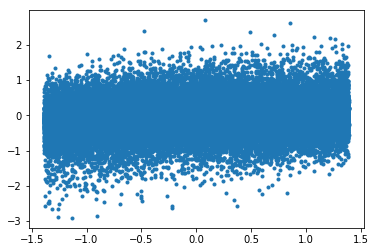

In [22]:
model = LinearRegression()
model.fit(encs_and_ys['test']['enc'].reshape(-1, encs_and_ys['test']['enc'].shape[2]), encs_and_ys['test']['y'].reshape(-1))
y_pred = model.predict(full_encs)
res = full_ys - y_pred
plt.plot(full_ys, res, '.')

## R^2 based on distance to reference object

In [38]:
def get_distances(col_sample):
    adjacencies = defaultdict(set)
    for a, b in col_sample:
        adjacencies[a].add(b)
        adjacencies[b].add(a)
    # Just use DFS, we're lazy
    n_obj = max([x[1] for x in col_sample]) + 1
    def dfs_dist(target, cur, depth, visited):
        if cur == target:
            return depth
        if cur in visited:
            return 1000000
        visited.add(cur)
        dists = []
        for neighbor in adjacencies[cur]:
            dists += [dfs_dist(target, neighbor, depth+1, visited)]
        return min(dists)
    dists = []
    for target in range(n_obj):
        dists += [dfs_dist(target, 0, 0, set())]
    return dists

In [44]:
encs_by_dist = [[] for i in range(9)]
ys_by_dist = [[] for i in range(9)]
for dset in dset_names:
    for i, col_sample in enumerate(collisions[dset]):
        distances = get_distances(col_sample)
        for obj_num in range(len(distances)):
            encs_by_dist[distances[obj_num]] += [encs_and_ys[dset]['enc'][i,obj_num,:]]
            ys_by_dist[distances[obj_num]] += [encs_and_ys[dset]['y'][i,obj_num]]
encs_by_dist = [np.stack(x, axis=0) for x in encs_by_dist]
ys_by_dist = [np.stack(x, axis=0) for x in ys_by_dist]

#### In sample R^2 based on distance

In [50]:
for i in range(9):
    model = LinearRegression()
    model.fit(encs_by_dist[i], ys_by_dist[i])
    print("Dist: {} In sample R^2: {}".format(i, model.score(encs_by_dist[i], ys_by_dist[i])))

Dist: 0 In sample R^2: 1.0
Dist: 1 In sample R^2: 0.8602227008129674
Dist: 2 In sample R^2: 0.7884613351563159
Dist: 3 In sample R^2: 0.7374396297110382
Dist: 4 In sample R^2: 0.6878252389139089
Dist: 5 In sample R^2: 0.6687444015693227
Dist: 6 In sample R^2: 0.6787887934701775
Dist: 7 In sample R^2: 0.6863919692831132
Dist: 8 In sample R^2: 0.780978567646734


#### R^2 trained on distance of 1

In [55]:
model = LinearRegression()
model.fit(np.concatenate(encs_by_dist[0:2], axis=0), np.concatenate(ys_by_dist[0:2], axis=0))
for i in range(9):
    print("Dist: {} OOS R^2: {}".format(i, model.score(encs_by_dist[i], ys_by_dist[i])))

Dist: 0 OOS R^2: 0.0
Dist: 1 OOS R^2: 0.8600226213962056
Dist: 2 OOS R^2: 0.7855876068725834
Dist: 3 OOS R^2: 0.7236279676932248
Dist: 4 OOS R^2: 0.6603492449600376
Dist: 5 OOS R^2: 0.6322167923898515
Dist: 6 OOS R^2: 0.6174838281693718
Dist: 7 OOS R^2: 0.6346759727769975
Dist: 8 OOS R^2: 0.6358134682391264


In [54]:
model = LinearRegression()
model.fit(full_encs_comb, full_ys_comb)
for i in range(9):
    print("Dist: {} OOS R^2: {}".format(i, model.score(encs_by_dist[i], ys_by_dist[i])))

Dist: 0 OOS R^2: 0.0
Dist: 1 OOS R^2: 0.8572582972795297
Dist: 2 OOS R^2: 0.7882556893111907
Dist: 3 OOS R^2: 0.7327744016192553
Dist: 4 OOS R^2: 0.6752197033139539
Dist: 5 OOS R^2: 0.6501477775065531
Dist: 6 OOS R^2: 0.6426504832949043
Dist: 7 OOS R^2: 0.6555506801290543
Dist: 8 OOS R^2: 0.6552055443557447


In [60]:
for i in range(9):
    print("Dist: {} Num Samples: {:5} ({:.3f})".format(i, encs_by_dist[i].shape[0], float(encs_by_dist[i].shape[0]) / sum(x.shape[0] for x in encs_by_dist)))

Dist: 0 Num Samples: 15000 (0.167)
Dist: 1 Num Samples: 34333 (0.381)
Dist: 2 Num Samples: 20834 (0.231)
Dist: 3 Num Samples: 10450 (0.116)
Dist: 4 Num Samples:  5488 (0.061)
Dist: 5 Num Samples:  2552 (0.028)
Dist: 6 Num Samples:   986 (0.011)
Dist: 7 Num Samples:   303 (0.003)
Dist: 8 Num Samples:    54 (0.001)


In [63]:
def f(dset):
    encs_by_dist = [[] for i in range(num_obj[dset])]
    ys_by_dist = [[] for i in range(num_obj[dset])]
    for i, col_sample in enumerate(collisions[dset]):
        distances = get_distances(col_sample)
        for obj_num in range(len(distances)):
            encs_by_dist[distances[obj_num]] += [encs_and_ys[dset]['enc'][i,obj_num,:]]
            ys_by_dist[distances[obj_num]] += [encs_and_ys[dset]['y'][i,obj_num]]
    encs_by_dist = [np.stack(x, axis=0) for x in encs_by_dist]
    ys_by_dist = [np.stack(x, axis=0) for x in ys_by_dist]
    model = LinearRegression()
    model.fit(full_encs_comb, full_ys_comb)
    for i in range(num_obj[dset]):
        print("Dist: {} OOS R^2: {}".format(i, model.score(encs_by_dist[i], ys_by_dist[i])))

In [65]:
print('test')
f('test')

print('\nobj3')
f('obj3')

print('\nobj9')
f('obj9')

test
Dist: 0 OOS R^2: 0.0
Dist: 1 OOS R^2: 0.9088300074967527
Dist: 2 OOS R^2: 0.857272392672901
Dist: 3 OOS R^2: 0.792325102195347
Dist: 4 OOS R^2: 0.7179863671841482
Dist: 5 OOS R^2: 0.7080586822910505

obj3
Dist: 0 OOS R^2: 0.0
Dist: 1 OOS R^2: 0.9175315033051679
Dist: 2 OOS R^2: 0.8418598110306521

obj9
Dist: 0 OOS R^2: 0.0
Dist: 1 OOS R^2: 0.7971531353795843
Dist: 2 OOS R^2: 0.7141606043731827
Dist: 3 OOS R^2: 0.6944681007380213
Dist: 4 OOS R^2: 0.6555184816078597
Dist: 5 OOS R^2: 0.6382899824933859
Dist: 6 OOS R^2: 0.6414646567335529
Dist: 7 OOS R^2: 0.6547360916664108
Dist: 8 OOS R^2: 0.6544881748828255
